In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
class FraudDetectionSystem:
    def __init__(self):
        """Initialize the Fraud Detection System with necessary attributes"""
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.model = None

    def load_data(self):
        """
        Generate synthetic fraud data using make_classification
        This simulates real credit card transaction data with fraud labels
        """
        # Generate synthetic data with imbalanced classes (fraud is minority class)
        X, y = make_classification(
            n_samples=10000,
            n_features=20,
            n_informative=15,
            n_redundant=5,
            weights=[0.97, 0.03],  # 3% fraud transactions
            random_state=42
        )

        # Convert to DataFrame with meaningful feature names
        feature_names = [f'feature_{i}' for i in range(20)]
        self.data = pd.DataFrame(X, columns=feature_names)
        self.data['fraud'] = y

        print("Data loaded successfully!")
        print(f"Shape of dataset: {self.data.shape}")
        return self.data

    def explore_data(self):
        """
        Perform Exploratory Data Analysis (EDA) on the dataset
        Creates visualizations and prints summary statistics
        """
        print("\nExploratory Data Analysis:")
        print("-" * 50)

        # Basic statistics
        print("\nClass distribution:")
        print(self.data['fraud'].value_counts(normalize=True))

        # Create visualizations
        plt.figure(figsize=(15, 5))

        # Plot 1: Class distribution
        plt.subplot(1, 2, 1)
        sns.countplot(data=self.data, x='fraud')
        plt.title('Distribution of Fraud vs Non-Fraud')

        # Plot 2: Correlation heatmap
        plt.subplot(1, 2, 2)
        correlation_matrix = self.data.corr()
        sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Heatmap')

        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """
        Preprocess the data:
        1. Split into training and testing sets
        2. Scale the features using StandardScaler
        """
        # Split features and target
        X = self.data.drop('fraud', axis=1)
        y = self.data['fraud']

        # Split into train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale the features
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

        print("Data preprocessing completed!")
        print(f"Training set shape: {self.X_train.shape}")
        print(f"Testing set shape: {self.X_test.shape}")

    def train_model(self):
        """
        Train a Random Forest model with hyperparameter tuning using GridSearchCV
        """
        # Initialize the model
        base_model = RandomForestClassifier(random_state=42)

        # Define hyperparameter grid
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        # Perform GridSearchCV
        self.model = GridSearchCV(
            base_model,
            param_grid,
            cv=5,
            scoring='f1',
            n_jobs=-1
        )

        # Train the model
        self.model.fit(self.X_train, self.y_train)

        print("\nModel Training Completed!")
        print(f"Best parameters: {self.model.best_params_}")
        print(f"Best cross-validation score: {self.model.best_score_:.3f}")

    def evaluate_model(self):
        """
        Evaluate the model using various metrics and create visualization
        """
        # Make predictions
        y_pred = self.model.predict(self.X_test)

        # Print classification report
        print("\nClassification Report:")
        print("-" * 50)
        print(classification_report(self.y_test, y_pred))

        # Calculate ROC curve and AUC
        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def get_feature_importance(self):
        """
        Calculate and visualize feature importance
        """
        # Get feature importance
        importance = self.model.best_estimator_.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': [f'feature_{i}' for i in range(20)],
            'importance': importance
        })

        # Sort by importance
        feature_importance = feature_importance.sort_values(
            'importance', ascending=False
        )

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
        plt.title('Top 10 Most Important Features')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()


Data loaded successfully!
Shape of dataset: (10000, 21)

Exploratory Data Analysis:
--------------------------------------------------

Class distribution:
fraud
0    0.966
1    0.034
Name: proportion, dtype: float64


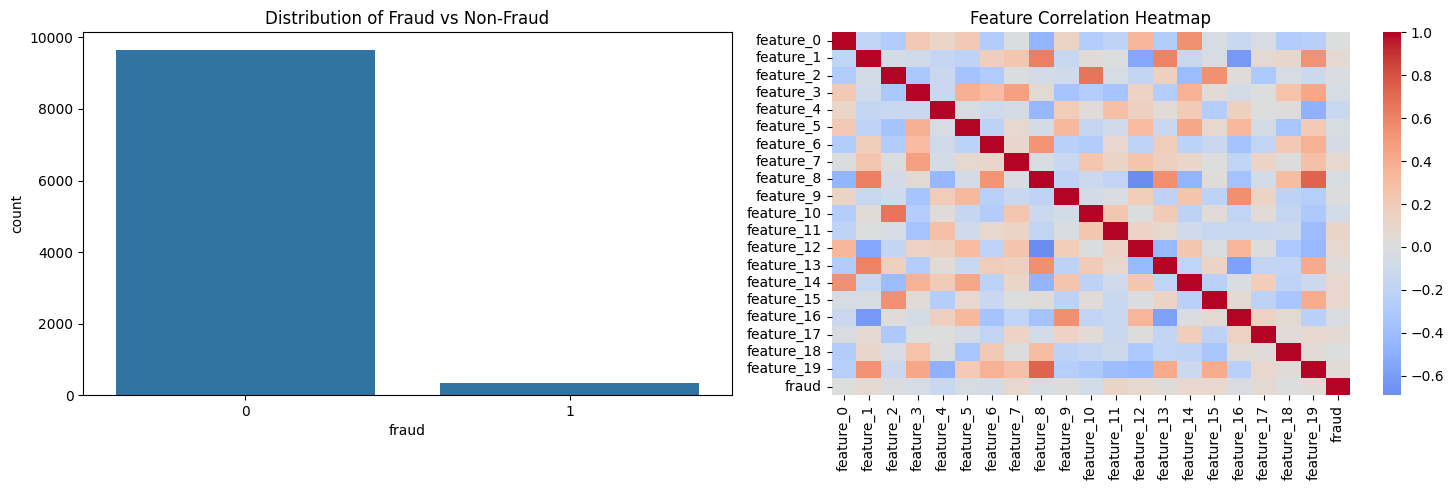

Data preprocessing completed!
Training set shape: (8000, 20)
Testing set shape: (2000, 20)

Model Training Completed!
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.335

Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1932
           1       1.00      0.26      0.42        68

    accuracy                           0.97      2000
   macro avg       0.99      0.63      0.70      2000
weighted avg       0.98      0.97      0.97      2000



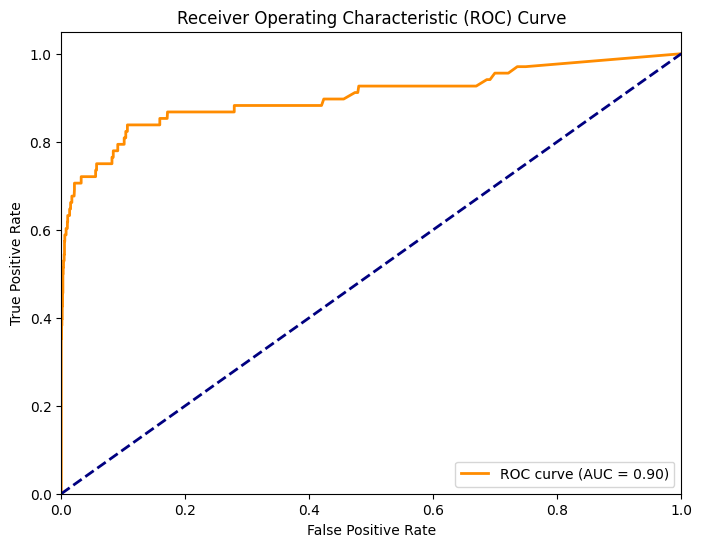

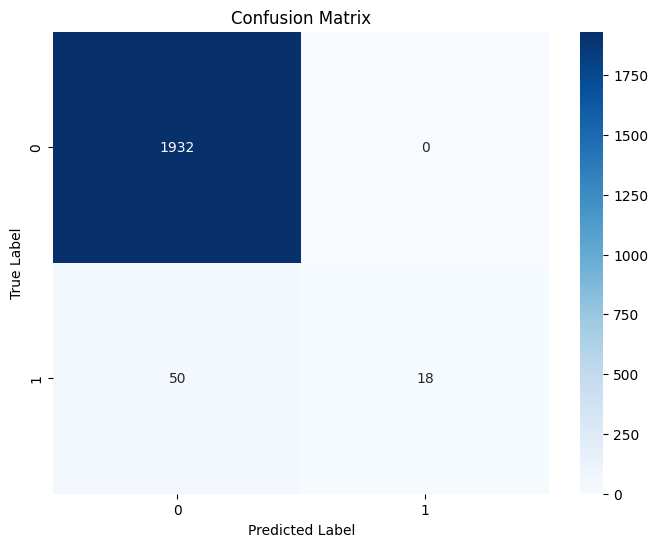

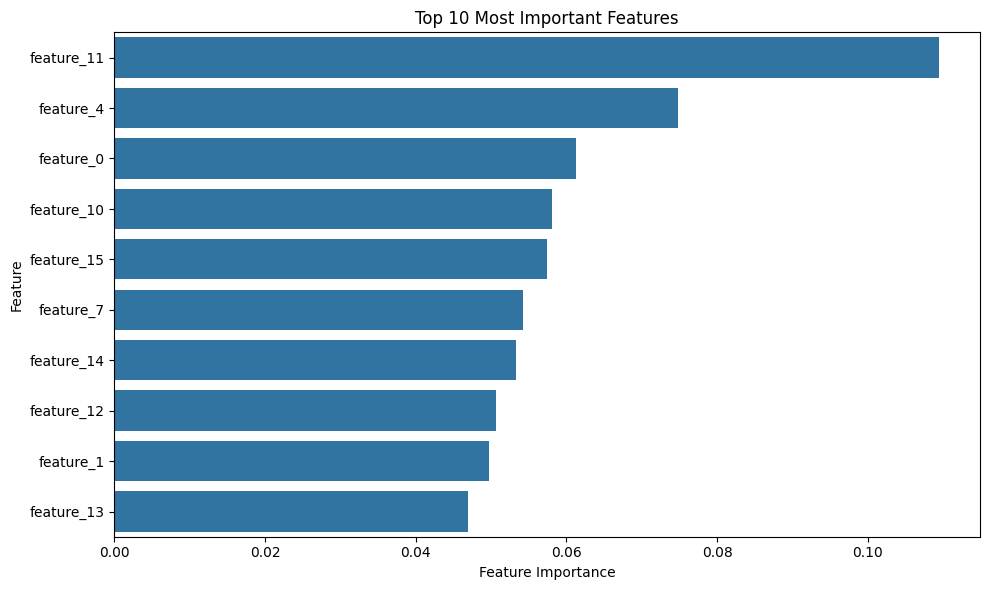

In [4]:
# Main execution
if __name__ == "__main__":
    # Initialize the fraud detection system
    fraud_detector = FraudDetectionSystem()

    # Execute the complete pipeline
    fraud_detector.load_data()
    fraud_detector.explore_data()
    fraud_detector.preprocess_data()
    fraud_detector.train_model()
    fraud_detector.evaluate_model()
    fraud_detector.get_feature_importance()